In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [2]:
args = Namespace(
    train_pos="data/imdb/train_pos.csv",
    train_neg="data/imdb/train_neg.csv",
    test_pos ="data/imdb/test_pos.csv", 
    test_neg ="data/imdb/test_neg.csv", 
    val_prop=0.1, # validation propotion
#     tr_pos = 12500,
#     tr_neg = 12500,
#     tt_pos = 12500,
#     tt_neg = 12500,
    tr_pos = 500,
    tr_neg = 500,
    tt_pos = 10,
    tt_neg = 10,
    output_csv="data/imdb/output.csv",
    review_length = 500
)

In [3]:
train_pos = pd.read_csv(args.train_pos, header=None, names=['rating', 'review'])
train_neg = pd.read_csv(args.train_neg, header=None, names=['rating', 'review'])
test_pos = pd.read_csv(args.test_pos, header=None, names=['rating', 'review'])
test_neg = pd.read_csv(args.test_neg, header=None, names=['rating', 'review'])

## how many tokens?

In [4]:
num_of_tokens_train = []
for review in train_pos.review:
    num_of_tokens_train.append(len(review.split(" ")))
for review in train_neg.review:
    num_of_tokens_train.append(len(review.split(" ")))
num_of_tokens_test = []
for review in test_pos.review:
    num_of_tokens_test.append(len(review.split(" ")))
for review in test_neg.review:
    num_of_tokens_test.append(len(review.split(" ")))

In [14]:
np.argmax(num_of_tokens_train)

1846

In [17]:
np.argmax(num_of_tokens_test)

7420

(0.0, 1940.0)

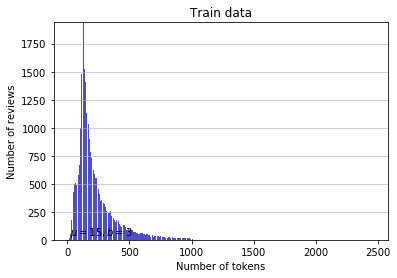

In [22]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=num_of_tokens_train, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of tokens')
plt.ylabel('Number of reviews')
plt.title('Train data')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 1600.0)

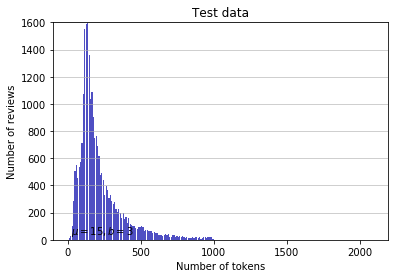

In [23]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=num_of_tokens_test, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of tokens')
plt.ylabel('Number of reviews')
plt.title('Test data')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## downsample dataset

In [5]:
"""
for steady performance, simply take the first n rows
"""

data_total= pd.DataFrame()

data_total = data_total.append(train_pos[0:args.tr_pos],ignore_index=True)
data_total = data_total.append(train_neg[0:args.tr_neg],ignore_index=True)

data_total = data_total.append(test_pos[0:args.tt_pos],ignore_index=True)
data_total = data_total.append(test_neg[0:args.tt_neg],ignore_index=True)



"""
assign splits to all data points, including splitting validation set
"""
data_total.loc[:,"split"] = "train"

data_total.iloc[args.tr_pos+args.tr_neg-1:,2] = "test"

data_total.iloc[int(args.tr_pos*(1-args.val_prop)):args.tr_pos,2] = "val"
data_total.iloc[int(args.tr_pos+args.tr_neg*(1-args.val_prop)):args.tr_pos+args.tr_neg,2] = "val"


In [6]:
# check the split value
data_total.split.value_counts()

train    900
val      100
test      20
Name: split, dtype: int64

In [6]:
data_total.head()

,rating,review,split
0,pos,for a movie that gets no respect there sure ar...,train
1,pos,bizarre horror movie filled with famous faces ...,train
2,pos,a solid if unremarkable film matthau as einste...,train
3,pos,its a strange feeling to sit alone in a theate...,train
4,pos,you probably all already know this by now but ...,train


## truancating reviews for further usage

In [5]:
for i, review in enumerate(data_total.review):
    data_total.iloc[i,1] = ' '.join(review.split()[:args.review_length])

(0.0, 320.0)

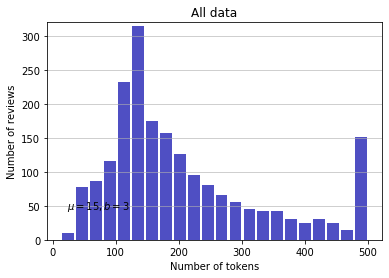

In [23]:
num_of_tokens = []
for review in data_total.review:
    num_of_tokens.append(len(review.split(" ")))
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=num_of_tokens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of tokens')
plt.ylabel('Number of reviews')
plt.title('All data')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [8]:
data_pos = data_total[data_total.rating=="pos"]
for portion in ["train", "test"]:
    data_pos[data_pos.split==portion].review.to_csv("data/imdb/pos/"+portion+".txt", index=False)
data_pos[data_pos.split=="val"].review.to_csv("data/imdb/pos/dev.txt",index=False)

/Users/elisa/miniconda3/envs/lucky/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elisa/miniconda3/envs/lucky/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [9]:
data_neg = data_total[data_total.rating=="neg"]
for portion in ["train", "test"]:
    data_neg[data_neg.split==portion].review.to_csv("data/imdb/neg/"+portion+".txt", index=False)
data_neg[data_neg.split=="val"].review.to_csv("data/imdb/neg/dev.txt",index=False)

/Users/elisa/miniconda3/envs/lucky/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elisa/miniconda3/envs/lucky/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [16]:
data_pos[data_pos.split=="train"].review.to_csv("data/imdb/train.txt", index=False)

/Users/elisa/miniconda3/envs/lucky/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [7]:
data_total.to_csv(args.output_csv, index=False)